In [1]:
""" Resize the notbook to full width, to fit more code and images """
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

""" some basic packages and settings to show images inline """
import numpy as np
import torch
import torch.distributions as dstr
import itertools
import torchvision
import torchvision.transforms as transforms
from tools import Dataset_to_XY, DataXY

import lovely_tensors as lt
lt.monkey_patch()
from lovely_numpy import lo

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation

""" automatically reload included modules (need to run import command to trigger reloading) """
%load_ext autoreload
%autoreload 2

""" Controls for figure sizes to change """
import matplotlib
plt.rcParams.update({'errorbar.capsize': 1})
# VoMi: Configure figure fonts
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['cmr10']  # This sets the Computer Modern Roman font
matplotlib.rcParams['text.usetex'] = False  # Ensure LaTeX is not being used for rendering
matplotlib.rcParams['axes.unicode_minus'] = False

# Alternatively, you can specify other font properties if needed
matplotlib.rcParams['font.size'] = 14  # Set the global font size
matplotlib.rcParams['axes.titlesize'] = 14  # Set the axes title font size
matplotlib.rcParams['axes.labelsize'] = 12  # Set the axes labels font size
matplotlib.rcParams['xtick.labelsize'] = 12  # Set the x-tick labels font size
matplotlib.rcParams['ytick.labelsize'] = 12  # Set the y-tick labels font size
matplotlib.rcParams['legend.fontsize'] = 12  # Set the legend font size

""" Lab support code """
import lab

def save_jpg(file_name):
    plt.savefig(file_name, bbox_inches='tight', dpi=300, pad_inches=0)

In [2]:
# query if we have GPU
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device: {dev}')

# Global datasets
transform = transforms.Compose([transforms.ToTensor(), 
                    transforms.Normalize((0.1307,), (0.3081,)),
                    transforms.Lambda(torch.flatten)]) 
# training and validation sets
train_set = Dataset_to_XY(torchvision.datasets.MNIST('./data', download=True, train=True, transform=transform))
#train_set, val_set = train_set.split(valid_size=0.1)

# test set
test_set = Dataset_to_XY(torchvision.datasets.MNIST('./data', download=True, train=False, transform=transform))

print(f'Size of train set {len(train_set)}')
print(f'Size of test set {len(test_set)}')

#
# dataloaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=0)
#val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False, num_workers=0)
#test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=0)
#

Using device: cpu
Size of train set 60000
Size of test set 10000


In [3]:
def save_model(model, name):
    torch.save(model.state_dict(), f'models/saved-model-{name}')

def load_model(model, name):
    model.load_state_dict(torch.load(f'models/saved-model-{name}'))
    model.to(dev)

def normalize_tensor(qimg):
    qimg = qimg - qimg.min()
    qimg /= qimg.max()
    return qimg

def show_image(image, where = None, normalize = True):    
    qimg = -image.reshape(28,-1).cpu().detach().numpy()
    if normalize:
        qimg = normalize_tensor(qimg)

    img = np.stack((qimg, qimg, qimg), axis=-1)   # expand to three channels
    if where is None:
        ret = plt.imshow(img)
        plt.axis('off')
    else:
        ret = where.imshow(img)
        where.axis('off')
    return ret

## Assignment 1
Implemented code in lab.py

## Assignment 2
Choose a reasonable $m$ and train constructed models.

In [32]:
zdim = 12 # Should be ok according to the paper (4 < z < 10000)
lr = 1e-3

# Layer widths are specified from the point of encoder x -> z, 784 -> zdim
models = {
    'A' : [],
    'B' : [32],
    'C' : [64],
    'D' : [60, 32],
    'E' : [60, 32, 20],
    #'B' : [256, 64],
    #'C' : [512, 256, 128, 64, 32],
}

models = {
    name : lab.VAE(zdim, lr, layer_widths) for name, layer_widths in models.items()
}

print('Num parameters')
print('Model & number of parameters & hidden layer widths \\\\ \\hline')
for name, vae in models.items():
    print(f'{name:30s} & {vae.get_num_parameters():10d} & {vae.layer_widths} \\\\')


Num parameters
Model & number of parameters & hidden layer widths \\ \hline
A                              &      29033 & [] \\
B                              &      52201 & [32] \\
C                              &     103593 & [64] \\
D                              &     100065 & [60, 32] \\
E                              &     100953 & [60, 32, 20] \\


In [33]:
epochs = 100
train_data = {}
for name, vae in models.items():
    print(f'Training model {name}')
    train_data[name] = lab.train(vae, train_loader, epochs)
    save_model(vae, name)

Training model A
Epoch 0: ELBO 1.222e+03, KL div 1.283e+01
Epoch 1: ELBO 7.876e+02, KL div 2.316e+01
Epoch 2: ELBO 7.177e+02, KL div 2.631e+01
Epoch 3: ELBO 7.165e+02, KL div 2.637e+01
Epoch 4: ELBO 7.162e+02, KL div 2.626e+01
Epoch 5: ELBO 7.162e+02, KL div 2.615e+01
Epoch 6: ELBO 7.161e+02, KL div 2.608e+01
Epoch 7: ELBO 7.160e+02, KL div 2.601e+01
Epoch 8: ELBO 7.159e+02, KL div 2.596e+01
Epoch 9: ELBO 7.159e+02, KL div 2.591e+01
Epoch 10: ELBO 7.159e+02, KL div 2.589e+01
Epoch 11: ELBO 7.158e+02, KL div 2.582e+01
Epoch 12: ELBO 7.157e+02, KL div 2.580e+01
Epoch 13: ELBO 7.157e+02, KL div 2.574e+01
Epoch 14: ELBO 7.157e+02, KL div 2.576e+01
Epoch 15: ELBO 7.156e+02, KL div 2.571e+01
Epoch 16: ELBO 7.157e+02, KL div 2.570e+01
Epoch 17: ELBO 7.156e+02, KL div 2.570e+01
Epoch 18: ELBO 7.156e+02, KL div 2.570e+01
Epoch 19: ELBO 7.156e+02, KL div 2.570e+01
Epoch 20: ELBO 7.156e+02, KL div 2.568e+01
Epoch 21: ELBO 7.156e+02, KL div 2.567e+01
Epoch 22: ELBO 7.156e+02, KL div 2.568e+01
Epoc

KeyboardInterrupt: 

In [ ]:
for name, vae in models.items():
    print(f'Loading model {name}')
    load_model(vae, name)

Loading model A
Loading model B
Loading model C
Loading model D
Loading model E


### Plot the ELBO statistic

KeyError: 'E'

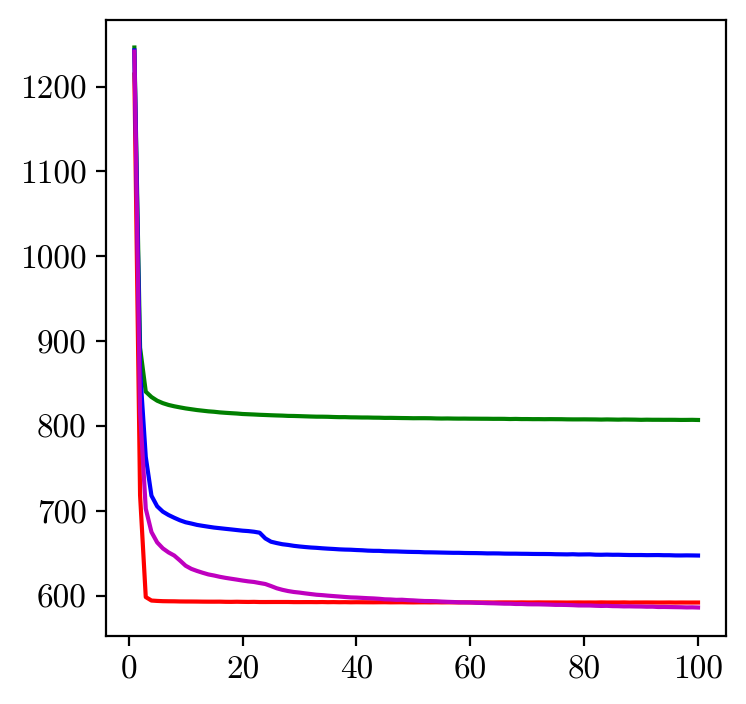

In [ ]:
fig = plt.figure(figsize=(4, 4), dpi=200)

plot_colors = ['r', 'g', 'b', 'm', 'orange']


x_axis = np.arange(epochs) + 1
for name, color in zip(models, plot_colors):
    nelbo, kl_div = train_data[name]
    plt.plot(x_axis, nelbo, color=color, label=name)

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("ELBO")
plt.grid(True)
save_jpg('figures/train-elbo.jpg')

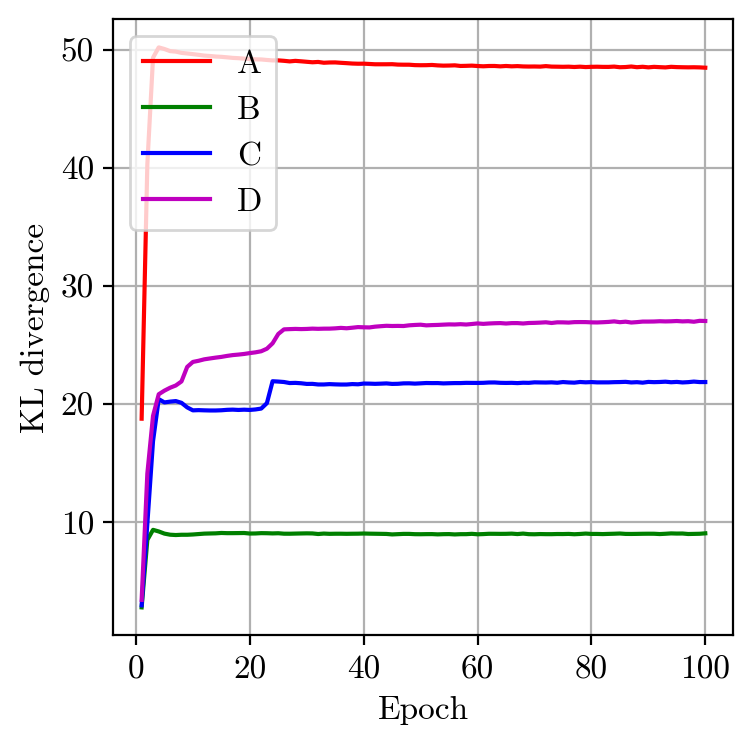

In [ ]:
fig = plt.figure(figsize=(4, 4), dpi=200)

for name, color in zip(models, plot_colors):
    nelbo, kl_div = train_data[name]
    plt.plot(x_axis, kl_div, color=color, label=name)

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("KL divergence")
plt.grid(True)
save_jpg('figures/train-kldiv.jpg')

### Plot reconstructed images

In [ ]:
batch_size = 16
batch_indices = np.random.choice(len(test_set), size=batch_size, replace=False)
batch =  test_set[batch_indices][0]

nrows = batch_size
ncols = len(models) + 1

No resampling first, i.e. exact reconstruction

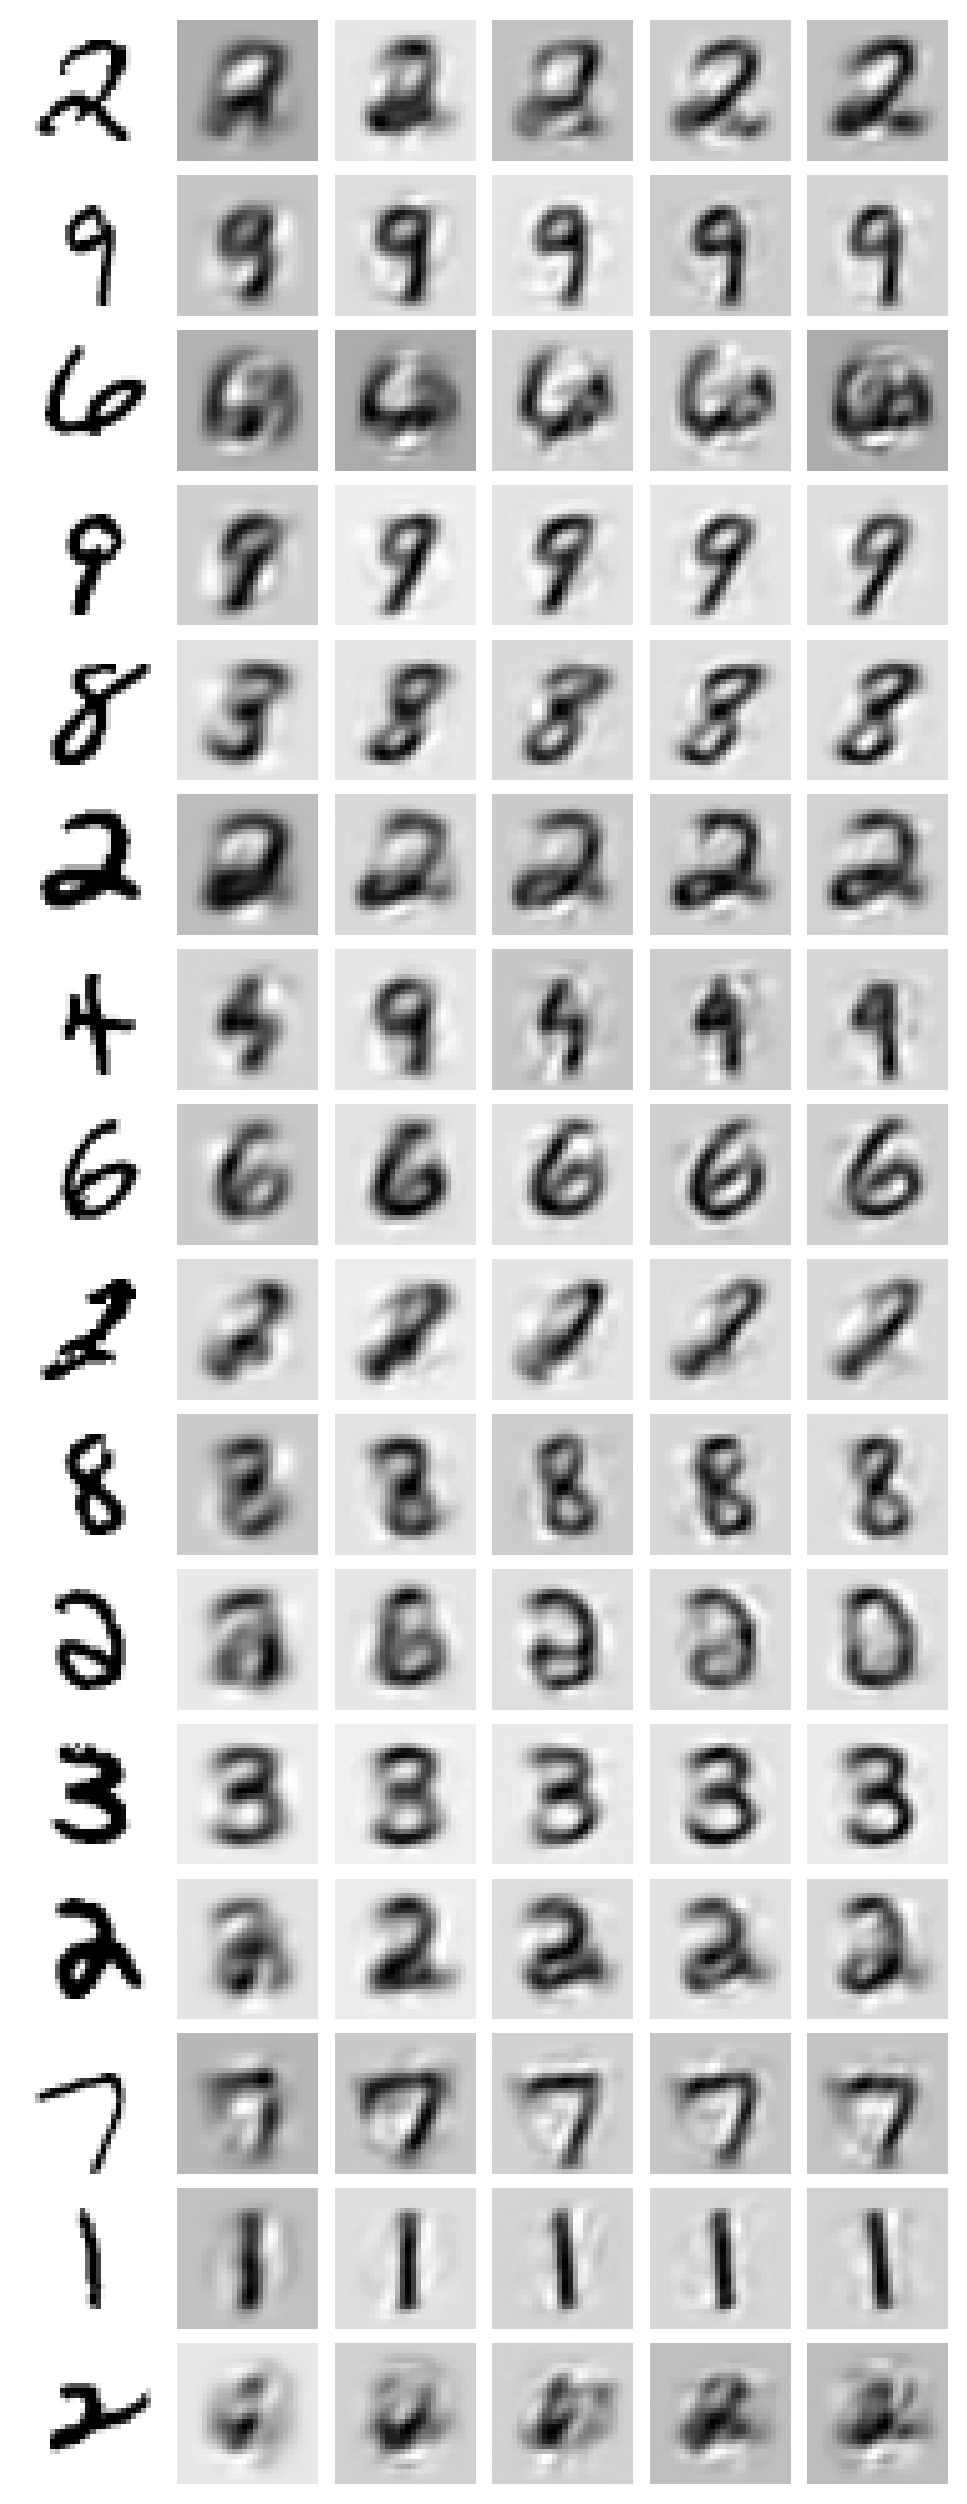

In [ ]:

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, dpi=200, figsize=(6,16))


images = [[None for _ in range(ncols)] for _ in range(nrows)]

# Original images
for i in range(batch_size):
    images[i][0] = batch[i]

# for each model:
for column, vae in enumerate(models.values(), start=1):
    z_mu, _ = vae.encoder(batch)
    x = vae.decoder(z_mu)

    for i in range(batch_size):
        images[i][column] = x[i]

for i, j in itertools.product(range(nrows), range(ncols)):
    show_image(images[i][j], axs[i, j])

plt.subplots_adjust(wspace=0.1, hspace=0.1)
#save_jpg('figures/decoding-exact.jpg')


With resampling, i.e. add noise and crease similar images.

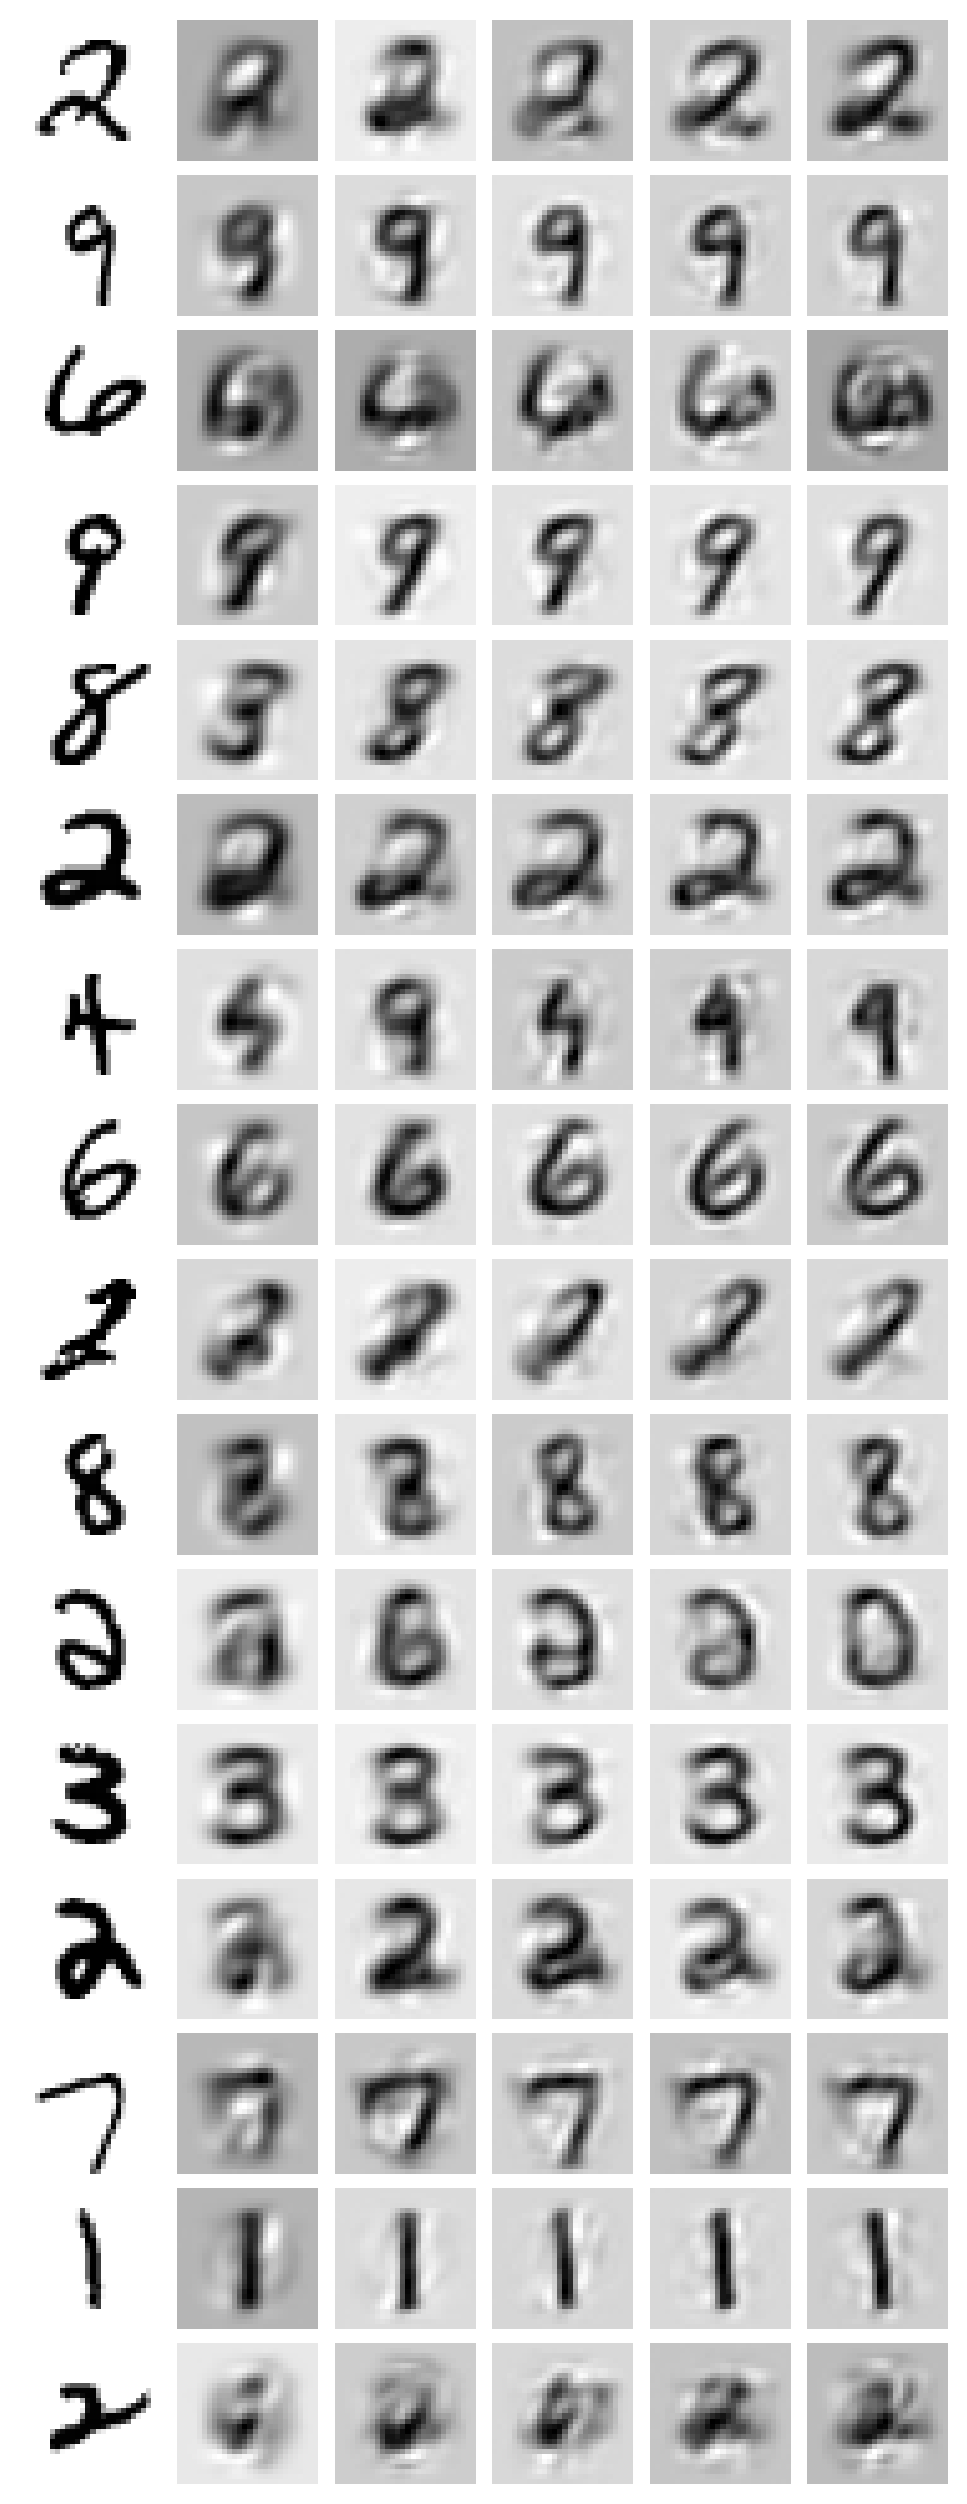

In [ ]:
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, dpi=200, figsize=(6,16))

images = [[None for _ in range(ncols)] for _ in range(nrows)]

# Original images
for i in range(batch_size):
    images[i][0] = batch[i]

# for each model:
for column, vae in enumerate(models.values(), start=1):
    z_mu, z_sigma = vae.encoder(batch)
    qz = dstr.Normal(z_mu, z_sigma)
    # sample with re-parametrization
    z = qz.rsample()
    x = vae.decoder(z)

    for i in range(batch_size):
        images[i][column] = x[i]

for i, j in itertools.product(range(nrows), range(ncols)):
    show_image(images[i][j], axs[i, j])

plt.subplots_adjust(wspace=0.1, hspace=0.1)
save_jpg('figures/reconstruction-resampled.jpg')


## Assignment 3

### Final values of ELBO for individual models:

In [ ]:
print('Model name & Terminal nELBO \\\\ \\hline')
for name in models:
    print(f'{name} & {train_data[name][0][-1]:.1f} \\\\')

Model name & Terminal nELBO \\ \hline
A & 591.9
B & 807.0
C & 647.3
D & 586.0


KeyError: 'E'

### Posterior collapse

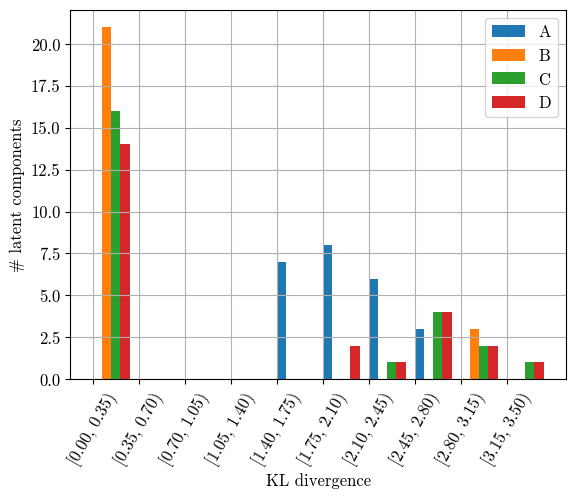

In [ ]:
batch_size = 256
batch_indices = np.random.choice(len(test_set), size=batch_size, replace=False)
batch =  test_set[batch_indices][0]

kl_div = {}
for j, (name, vae) in enumerate(models.items()):
    z_mu, z_sigma = vae.encoder(batch)
    kl_div[name] = []
    qz = dstr.Normal(z_mu, z_sigma)
    pz = dstr.Normal(torch.zeros((batch_size, zdim)), torch.ones((batch_size, zdim)))
    kl = dstr.kl_divergence(qz, pz).mean(0)
    kl_div[name] = kl.detach().numpy()

    data, edges = np.histogram(kl_div[name], range=(0, 3.5))
    width = 1 / (len(models) + 1) * (edges[1] - edges[0])
    plt.bar(edges[:-1] + (j+0.5)*width, data, width= width, label=name)
plt.ylabel('# latent components')
plt.xlabel('KL divergence')
xticks = [(left, f'[{left:.2f}, {right:.2f})') for left, right in zip(edges[:-1], edges[1:])]
plt.xticks(ticks=[center for center, label in xticks], labels=[label for center, label in xticks], rotation=60)
plt.legend()
plt.grid()
save_jpg('figures/posterior-collapse.jpg')


### Evaluating the decoder
get batch_size samples from N(0, 1)

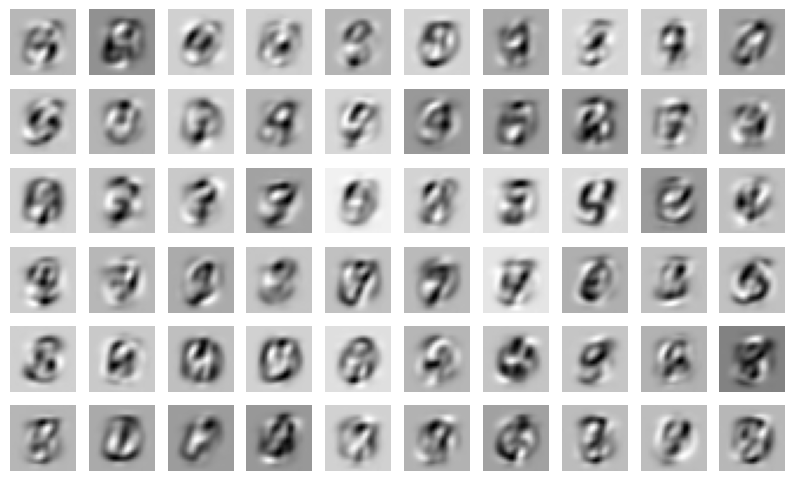

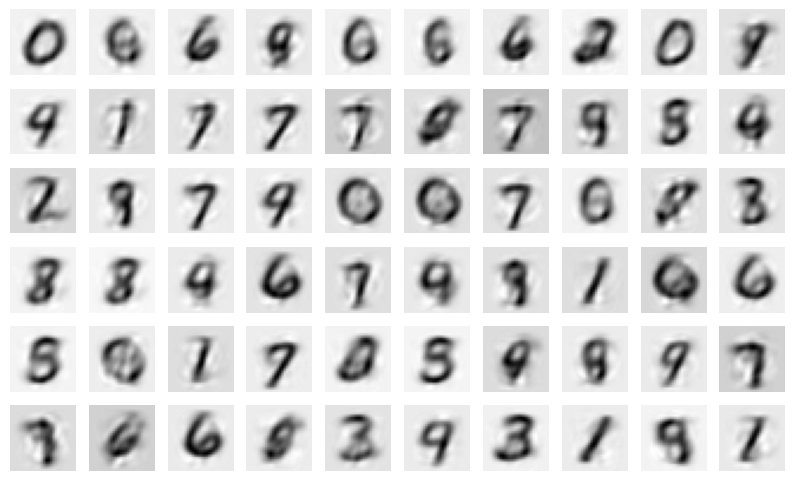

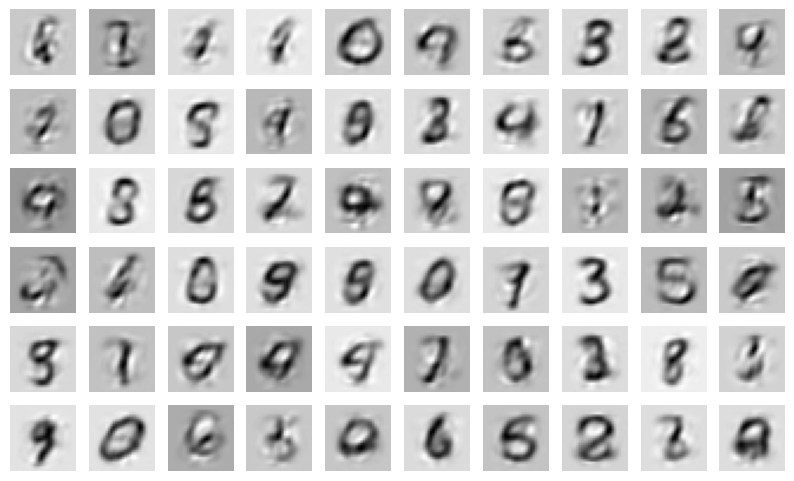

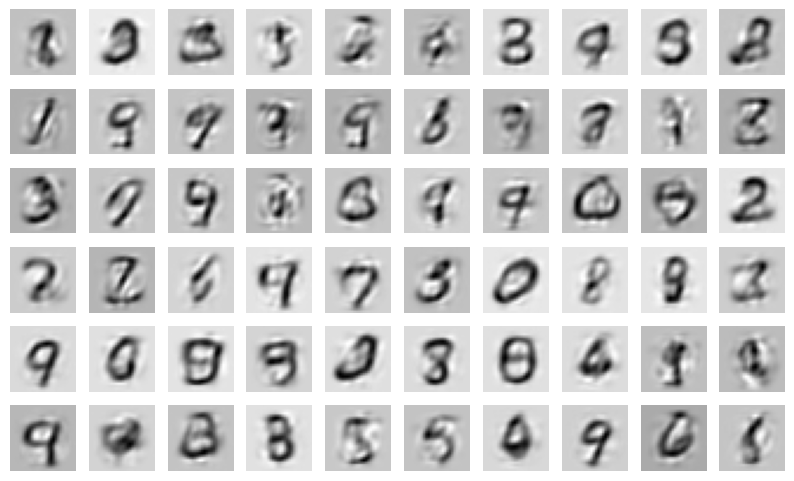

In [ ]:
batch_size = 60
pz = dstr.Normal(torch.zeros((batch_size,zdim)), torch.ones((batch_size,zdim)))
z_batch = pz.rsample()

def plot_random_images(name, vae):
    ncols = 10
    nrows = 6
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols, nrows))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

    x_batch = vae.decoder(z_batch)

    for i, x in enumerate(x_batch):
        show_image(x, axs.flat[i])

    save_jpg(f'figures/random-z-{name}.jpg')

for name, vae in models.items():
    plot_random_images(name, vae)

### Limiting distribution

Update frame = 0, x_batch = tensor[60, 784] n=47040 (0.2Mb) x∈[-3.443, 4.779] μ=0.009 σ=0.859
Update frame = 0, x_batch = tensor[60, 784] n=47040 (0.2Mb) x∈[-3.105, 4.730] μ=0.010 σ=0.873
Update frame = 0, x_batch = tensor[60, 784] n=47040 (0.2Mb) x∈[-3.242, 4.713] μ=0.007 σ=0.881
Update frame = 0, x_batch = tensor[60, 784] n=47040 (0.2Mb) x∈[-3.512, 5.196] μ=0.007 σ=0.893
Update frame = 1, x_batch = tensor[60, 784] n=47040 (0.2Mb) x∈[-3.965, 5.391] μ=-0.001 σ=0.904
Update frame = 2, x_batch = tensor[60, 784] n=47040 (0.2Mb) x∈[-3.984, 5.572] μ=-0.004 σ=0.924
Update frame = 3, x_batch = tensor[60, 784] n=47040 (0.2Mb) x∈[-3.826, 5.489] μ=-0.008 σ=0.940
Update frame = 4, x_batch = tensor[60, 784] n=47040 (0.2Mb) x∈[-4.456, 5.276] μ=-0.015 σ=0.953
Update frame = 5, x_batch = tensor[60, 784] n=47040 (0.2Mb) x∈[-4.914, 5.539] μ=-0.024 σ=0.961
Update frame = 6, x_batch = tensor[60, 784] n=47040 (0.2Mb) x∈[-5.355, 5.702] μ=-0.034 σ=0.971
Update frame = 7, x_batch = tensor[60, 784] n=47040 (0

KeyboardInterrupt: 

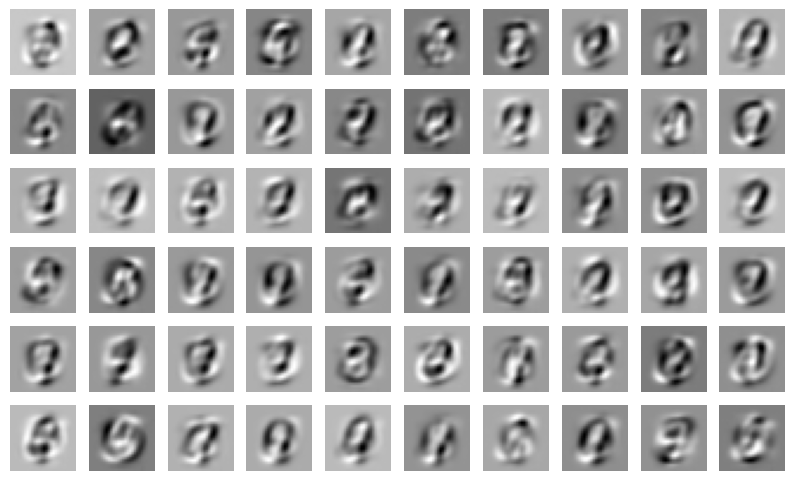

In [ ]:
batch_size = 60
pz = dstr.Normal(torch.zeros((batch_size,zdim)), torch.ones((batch_size,zdim)))
z_batch_start = pz.rsample()

x_batch = None
images = []
axs = None

# Update function for animation
def update_animation(frame):
    global x_batch
    global images
    global axs
    # start from the x from previous iteration.
    px = dstr.Normal(x_batch, torch.exp(vae.decoder.logsigma))
    # Sample a new one
    x_batch = px.rsample()
    # Encode it to get z 
    z_mu, z_sigma = vae.encoder(x_batch)
    qz = dstr.Normal(z_mu, z_sigma)
    # Sample a new z
    z_batch = qz.rsample()
    # get the next image batch
    x_batch = vae.decoder(z_batch)


    for i, x in enumerate(x_batch):
        show_image(x, axs.flat[i])
    print(f'Update {frame = }, {x_batch = }')
    return images

def plot_limiting_distribution(name, vae, num_frames):
    ncols = 10
    nrows = 6
    global x_batch
    global images
    global axs
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols, nrows))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

    torch.manual_seed(123)
    x_batch = vae.decoder(z_batch_start)
    for i, x in enumerate(x_batch):
        images += [show_image(x, axs.flat[i])]

    # Create the animation
    ani = animation.FuncAnimation(fig, update_animation, frames=num_frames, interval=200, blit=True)

    # Save the animation as an mp4 file (optional)
    ani.save(f'animation/animation-{name}.gif', writer=animation.PillowWriter(fps=5))

    save_jpg(f'figures/limiting-distrib-{name}.jpg')

    # Display the animation
    #plt.show()

with torch.no_grad():
    for name, vae in models.items():
        plot_limiting_distribution(name, vae, 100)